# Analisis Sentimen Ulasan DANA

DANA - Dompet Digital Indonesia dari Google Play Store.

## Install Dependencies

In [1]:
!pip install google-play-scraper pandas numpy scikit-learn matplotlib seaborn wordcloud PySastrawi nltk joblib -q


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: C:\Users\acer\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import os
import json
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

print("Semua library berhasil dimuat!")

Semua library berhasil dimuat!


## Data Acquisition

In [3]:
from google_play_scraper import reviews, Sort

APP_ID = "id.dana"
TARGET = 2000

semua_ulasan = []
token = None

try:
    while len(semua_ulasan) < TARGET:
        sisa = TARGET - len(semua_ulasan)
        batch = min(200, sisa)

        hasil, token = reviews(
            APP_ID,
            lang="id",
            country="id",
            sort=Sort.NEWEST,
            count=batch,
            continuation_token=token
        )

        if not hasil:
            break

        semua_ulasan.extend(hasil)
        print(f"Mengambil ulasan: {len(semua_ulasan)}/{TARGET}")

        if token is None:
            break

        time.sleep(1)

except Exception as e:
    print(f"Error: {e}")

print(f"\nTotal ulasan berhasil diambil: {len(semua_ulasan)}")

Mengambil ulasan: 200/2000
Mengambil ulasan: 400/2000
Mengambil ulasan: 600/2000
Mengambil ulasan: 800/2000
Mengambil ulasan: 1000/2000
Mengambil ulasan: 1200/2000
Mengambil ulasan: 1400/2000
Mengambil ulasan: 1600/2000
Mengambil ulasan: 1800/2000
Mengambil ulasan: 2000/2000

Total ulasan berhasil diambil: 2000


In [4]:
os.makedirs("data", exist_ok=True)

daftar = []
for u in semua_ulasan:
    daftar.append({
        "id_ulasan": u.get("reviewId", ""),
        "nama_pengguna": u.get("userName", ""),
        "isi_ulasan": u.get("content", ""),
        "bintang": u.get("score", 0),
        "tanggal_ulasan": u.get("at", ""),
        "jumlah_like": u.get("thumbsUpCount", 0),
    })

df = pd.DataFrame(daftar)

def tentukan_sentimen(bintang):
    if bintang >= 4:
        return "Positif"
    elif bintang == 3:
        return "Netral"
    else:
        return "Negatif"

df["sentimen"] = df["bintang"].apply(tentukan_sentimen)
df = df[df["isi_ulasan"].str.strip() != ""]
df = df.dropna(subset=["isi_ulasan"])

df.to_csv("data/ulasan_dana_mentah.csv", index=False, encoding="utf-8-sig")
print(f"Data disimpan: {len(df)} ulasan")
print("\nDistribusi Sentimen:")
print(df["sentimen"].value_counts())
df.head(5)

Data disimpan: 2000 ulasan

Distribusi Sentimen:
sentimen
Positif    1500
Negatif     414
Netral       86
Name: count, dtype: int64


,id_ulasan,nama_pengguna,isi_ulasan,bintang,tanggal_ulasan,jumlah_like,sentimen
0,31a5cd7f-ec2e-4b86-ac40-0462189d5f6e,Romi Sondia,jujur saya sangat kecewa untuk transaksi yang ...,1,2026-02-26 07:52:26,0,Negatif
1,b469ef59-f7ad-4635-95a0-7759beea3fb5,Cong Ipul,aplikasi x sangat bagus,5,2026-02-26 07:50:15,0,Positif
2,ecab1ae4-6479-4bb3-b111-953e7427c5c2,Rangga Pamungkas,Good joss,5,2026-02-26 07:45:38,0,Positif
3,21ec9438-1cdb-4092-99dc-9a08c765729b,Heri Yadi,mkon mantap aja pke akun dana,5,2026-02-26 07:43:28,0,Positif
4,45222a7d-d8e2-4602-91e8-908be418e0ee,Tilar Ningsih,0ke sip,5,2026-02-26 07:43:14,0,Positif


## Text Cleaning & Pre-processing

In [5]:
print("Memuat Stemmer & StopWord Bahasa Indonesia...")
hapus_sw = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

kamus_slang = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "g": "tidak",
    "ngga": "tidak", "nggak": "tidak", "kagak": "tidak",
    "yg": "yang", "yng": "yang", "drpd": "daripada",
    "dgn": "dengan", "dg": "dengan", "sm": "sama",
    "sy": "saya", "gue": "saya", "gw": "saya",
    "lo": "kamu", "lu": "kamu", "km": "kamu",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah",
    "blm": "belum", "blom": "belum", "blum": "belum",
    "dpt": "dapat", "bsa": "bisa", "bs": "bisa",
    "hrs": "harus", "krn": "karena", "karna": "karena",
    "tp": "tapi", "tpi": "tapi", "ttg": "tentang",
    "dl": "dulu", "dlu": "dulu",
    "bnyk": "banyak", "byk": "banyak",
    "msh": "masih", "masi": "masih",
    "bgt": "sangat", "banget": "sangat",
    "aja": "saja", "aj": "saja",
    "jg": "juga", "spt": "seperti",
    "lg": "lagi", "klo": "kalau", "kalo": "kalau",
    "dr": "dari", "utk": "untuk", "u": "untuk",
    "tdk": "tidak", "pd": "pada",
    "abis": "habis", "lbh": "lebih", "lbih": "lebih",
    "org": "orang", "emg": "memang", "emang": "memang",
    "knp": "kenapa", "tau": "tahu",
    "jgn": "jangan", "aplikasinya": "aplikasi", "appnya": "aplikasi",
}

def normalisasi_slang(teks):
    return " ".join([kamus_slang.get(k, k) for k in teks.split()])

def bersihkan_teks(teks):
    if pd.isna(teks) or str(teks).strip() == "":
        return ""
    teks = str(teks).lower()
    teks = re.sub(r"http\S+|www\.\S+", "", teks)
    teks = re.sub(r"@\w+|#\w+", "", teks)
    teks = teks.encode("ascii", "ignore").decode("ascii")
    teks = re.sub(r"\d+", "", teks)
    teks = re.sub(r"[^\w\s]", " ", teks)
    teks = re.sub(r"\s+", " ", teks).strip()
    teks = normalisasi_slang(teks)
    teks = hapus_sw.remove(teks)
    teks = stemmer.stem(teks)
    return teks.strip()

print("Fungsi pre-processing siap.")

Memuat Stemmer & StopWord Bahasa Indonesia...
Fungsi pre-processing siap.


In [6]:
print("Memproses teks... (mungkin beberapa menit)")
total = len(df)
hasil_bersih = []

for i, baris in df.iterrows():
    hasil_bersih.append(bersihkan_teks(baris["isi_ulasan"]))
    if (i + 1) % 200 == 0:
        print(f"  {i + 1}/{total} selesai...")

df["teks_bersih"] = hasil_bersih
df = df[df["teks_bersih"].str.strip() != ""]
df = df.dropna(subset=["teks_bersih"])

df.to_csv("data/ulasan_dana_bersih.csv", index=False, encoding="utf-8-sig")
print(f"\nSelesai. {len(df)} baris disimpan.")

Memproses teks... (mungkin beberapa menit)
  200/2000 selesai...
  400/2000 selesai...
  600/2000 selesai...
  800/2000 selesai...
  1000/2000 selesai...
  1200/2000 selesai...
  1400/2000 selesai...
  1600/2000 selesai...
  1800/2000 selesai...
  2000/2000 selesai...

Selesai. 1889 baris disimpan.


In [7]:
print("Contoh dari hasil pre-processing:\n")
for _, row in df.head(5).iterrows():
    asli = str(row["isi_ulasan"])[:100]
    bersih = str(row["teks_bersih"])[:100]
    print(f"SEBELUM  : {asli}")
    print(f"SESUDAH  : {bersih}")
    print(f"SENTIMEN : {row['sentimen']}")
    print()

Contoh dari hasil pre-processing:

SEBELUM  : jujur saya sangat kecewa untuk transaksi yang tidak saya buat dan saldo 380rb lenyap cuma cuma udah 
SESUDAH  : jujur kecewa transaksi saldo rb lenyap chat admin kayak niat bantu plis dana cari solusi biar saldo 
SENTIMEN : Negatif

SEBELUM  : aplikasi x sangat bagus
SESUDAH  : aplikasi bagus
SENTIMEN : Positif

SEBELUM  : Good joss
SESUDAH  : good joss
SENTIMEN : Positif

SEBELUM  : mkon mantap aja pke akun dana
SESUDAH  : mkon mantap pke akun dana
SENTIMEN : Positif

SEBELUM  : 0ke sip
SESUDAH  : sip
SENTIMEN : Positif



## Feature Engineering, Modeling & Evaluation

In [8]:
os.makedirs("model", exist_ok=True)
os.makedirs("gambar", exist_ok=True)

df = pd.read_csv("data/ulasan_dana_bersih.csv")
df = df.dropna(subset=["teks_bersih", "sentimen"])
df = df[df["teks_bersih"].str.strip() != ""]

distribusi = df["sentimen"].value_counts()
print(f"Data: {len(df)} baris\n")
print("Distribusi Sentimen:")
print(distribusi)

Data: 1889 baris

Distribusi Sentimen:
sentimen
Positif    1393
Negatif     413
Netral       83
Name: count, dtype: int64


In [9]:
X = df["teks_bersih"]
y = df["sentimen"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vektorizer = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
)

X_train_tfidf = vektorizer.fit_transform(X_train)
X_test_tfidf = vektorizer.transform(X_test)

print(f"Data latih : {len(X_train)} sampel")
print(f"Data uji   : {len(X_test)} sampel")
print(f"Jumlah fitur TF-IDF: {X_train_tfidf.shape[1]}")

Data latih : 1511 sampel
Data uji   : 378 sampel
Jumlah fitur TF-IDF: 976


In [10]:
print("Melatih model SVM...")

svm = LinearSVC(C=1.0, max_iter=5000, random_state=42, class_weight="balanced")
model = CalibratedClassifierCV(svm, cv=3)
model.fit(X_train_tfidf, y_train)
print("Model selesai dilatih.")

Melatih model SVM...
Model selesai dilatih.


### Evaluasi Model

In [11]:
prediksi = model.predict(X_test_tfidf)
akurasi = accuracy_score(y_test, prediksi)
label_unik = sorted(y.unique())

print(f"Akurasi: {akurasi * 100:.2f}%")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, prediksi, target_names=label_unik))

laporan = classification_report(y_test, prediksi, target_names=label_unik, output_dict=True)
pd.DataFrame(laporan).transpose().to_csv("data/laporan_evaluasi.csv", encoding="utf-8-sig")

Akurasi: 81.22%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.63      0.60      0.62        83
      Netral       0.00      0.00      0.00        16
     Positif       0.86      0.92      0.89       279

    accuracy                           0.81       378
   macro avg       0.50      0.51      0.50       378
weighted avg       0.77      0.81      0.79       378



### Visualisasi Confusion Matrix

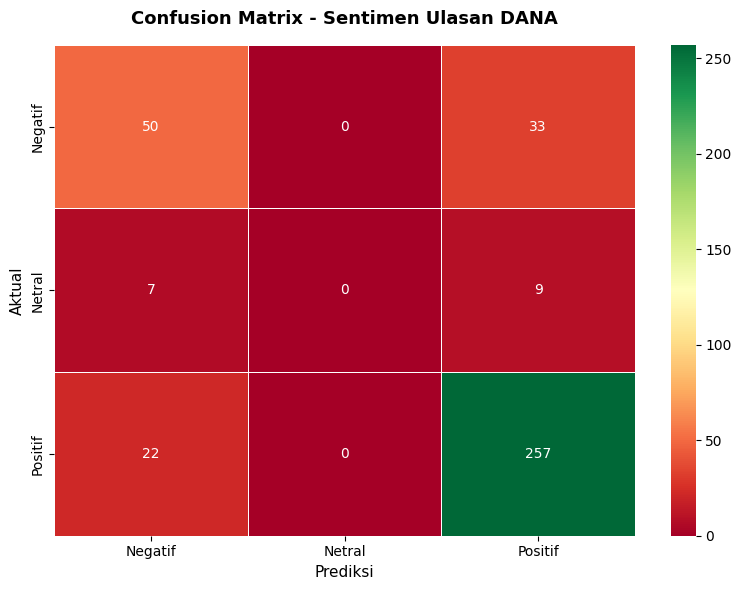

In [12]:
cm = confusion_matrix(y_test, prediksi, labels=label_unik)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdYlGn",
            xticklabels=label_unik, yticklabels=label_unik,
            linewidths=0.5, ax=ax)
ax.set_title("Confusion Matrix - Sentimen Ulasan DANA", fontsize=13, fontweight="bold", pad=15)
ax.set_xlabel("Prediksi", fontsize=11)
ax.set_ylabel("Aktual", fontsize=11)
plt.tight_layout()
plt.savefig("gambar/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

### Visualisasi Distribusi Sentimen

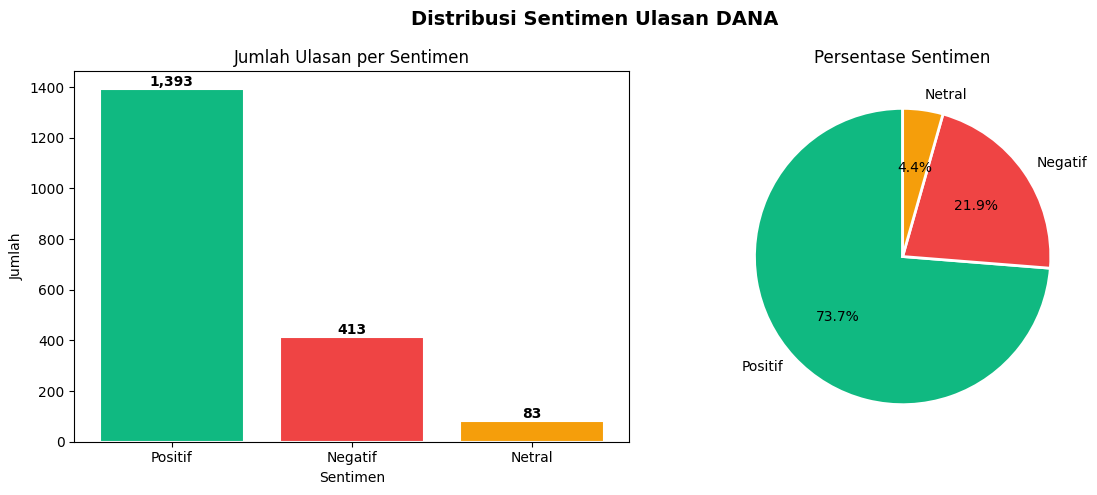

In [13]:
palet = {"Positif": "#10b981", "Netral": "#f59e0b", "Negatif": "#ef4444"}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distribusi Sentimen Ulasan DANA", fontsize=14, fontweight="bold")

warna = [palet.get(k, "#6b7280") for k in distribusi.index]
batang = ax1.bar(distribusi.index, distribusi.values, color=warna, edgecolor="white", linewidth=1.5)
ax1.set_title("Jumlah Ulasan per Sentimen")
ax1.set_xlabel("Sentimen")
ax1.set_ylabel("Jumlah")
for p in batang:
    ax1.annotate(f"{p.get_height():,}",
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom", fontweight="bold")

ax2.pie(distribusi.values, labels=distribusi.index, colors=warna,
        autopct="%1.1f%%", startangle=90,
        wedgeprops=dict(edgecolor="white", linewidth=2))
ax2.set_title("Persentase Sentimen")
plt.tight_layout()
plt.savefig("gambar/distribusi_sentimen.png", dpi=150, bbox_inches="tight")
plt.show()

### Visualisasi Word Cloud per Sentimen

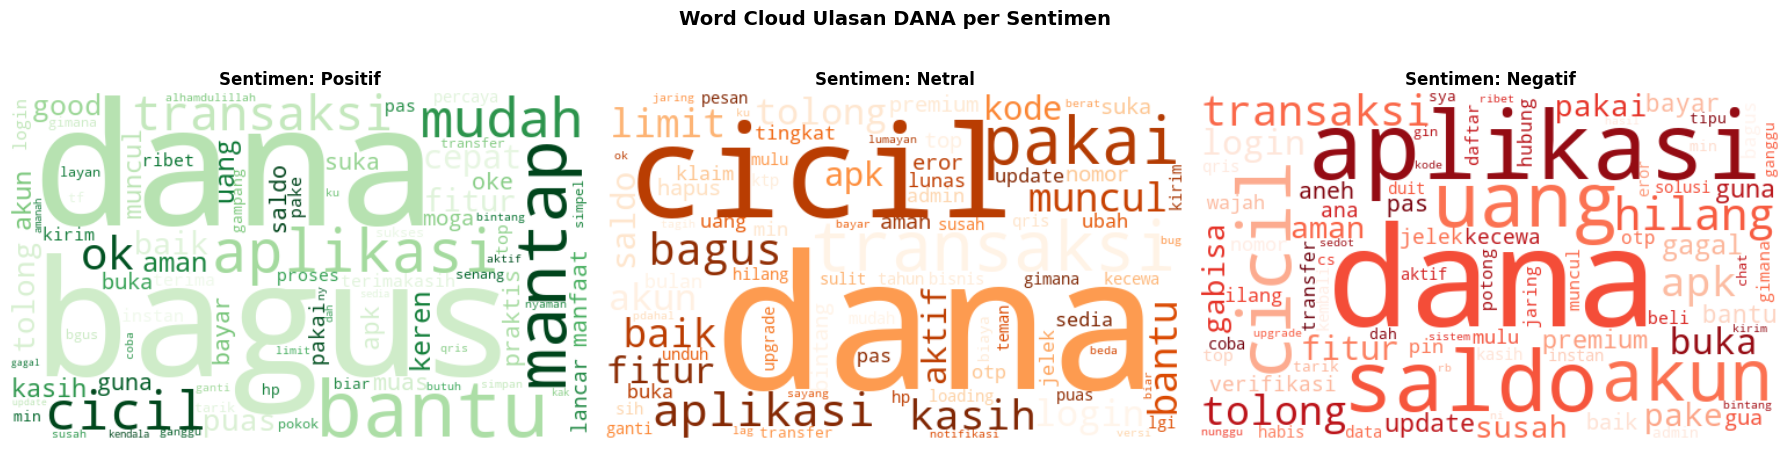

In [14]:
fig, sumbu = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Word Cloud Ulasan DANA per Sentimen", fontsize=14, fontweight="bold")

wc_cfg = {
    "Positif": {"cmap": "Greens", "ax": sumbu[0]},
    "Netral":  {"cmap": "Oranges", "ax": sumbu[1]},
    "Negatif": {"cmap": "Reds",    "ax": sumbu[2]},
}

for label, cfg in wc_cfg.items():
    teks = " ".join(df[df["sentimen"] == label]["teks_bersih"].tolist())
    if teks.strip():
        wc = WordCloud(width=500, height=300, background_color="white",
                       colormap=cfg["cmap"], max_words=80,
                       collocations=False).generate(teks)
        cfg["ax"].imshow(wc, interpolation="bilinear")
    cfg["ax"].set_title(f"Sentimen: {label}", fontsize=12, fontweight="bold")
    cfg["ax"].axis("off")

plt.tight_layout()
plt.savefig("gambar/wordcloud_sentimen.png", dpi=150, bbox_inches="tight")
plt.show()

### Simpan Model dan Metadata

In [15]:
joblib.dump(model, "model/model_sentimen.pkl")
joblib.dump(vektorizer, "model/vektorizer_tfidf.pkl")

metadata = {
    "akurasi": float(akurasi),
    "jumlah_data": len(df),
    "jumlah_latih": len(X_train),
    "jumlah_uji": len(X_test),
    "jumlah_fitur": int(X_train_tfidf.shape[1]),
    "kelas": label_unik,
    "distribusi": distribusi.to_dict(),
    "algoritma": "SVM (LinearSVC + CalibratedClassifierCV)",
}
for s in label_unik:
    if s in laporan:
        metadata[f"presisi_{s.lower()}"] = laporan[s].get("precision", 0)
        metadata[f"recall_{s.lower()}"] = laporan[s].get("recall", 0)
        metadata[f"f1_{s.lower()}"] = laporan[s].get("f1-score", 0)

with open("model/metadata_model.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Model: model/model_sentimen.pkl")
print("Vektor: model/vektorizer_tfidf.pkl")
print("Meta: model/metadata_model.json")
print(f"\nAkurasi akhir: {akurasi * 100:.2f}%")

Model: model/model_sentimen.pkl
Vektor: model/vektorizer_tfidf.pkl
Meta: model/metadata_model.json

Akurasi akhir: 81.22%
